### Détectection des faux billets avec Python

## 1. Preliminary

     *** Contexte ***

Identification des contrefaçons des billets en euros

Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

In [428]:
!python -V


Python 3.9.13


## 1.1 Install

In [429]:
#!pip install --upgrade seaborn
#!pip install --upgrade pandas
#!pip install pandas --user
#!pip install --upgrade numexpr
#!pip install --upgrade bottleneck

#!pip install --upgrade matplotlib
#!pip install matplotlib --user

# 1.2 Importation

## 1.2.1 Importation des librairies

In [430]:
#builtin
import os

In [431]:

#data
import pandas as pd
import numpy as np

In [432]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
%matplotlib inline

In [433]:
#machine learning
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## 2.1 chargement des fichiers

In [434]:
input_folder = r"C:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Data\0 Source"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')


## 2. Prétraitement des données

## 2.2 Exploration

In [435]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [436]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(train_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 1500.


In [437]:
# preview test data
test_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [438]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(test_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 5.


Note: On ne voit pas la colonne 'is_genuine' (la target) dans le dataset test_df. Notre objectif est alors de prédire la target par differentes algorithmes de machine learning scomme la regression logistique.

In [439]:
#Affichage des 5 dernieres lignes
train_df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25
1499,0.0,171.47,104.15,103.82,4.63,3.37,112.07


In [440]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
167,1.0,172.20,104.06,103.97,4.16,3.17,112.47
87,1.0,171.70,103.75,103.40,4.47,3.28,113.57
106,1.0,172.27,103.95,103.75,3.94,3.19,114.04
1163,0.0,172.34,104.36,103.83,6.03,3.44,111.44
215,1.0,172.05,104.08,103.66,4.49,3.24,113.23


In [441]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [442]:
#Information sur les colonnes
train_df.dtypes

is_genuine      float64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [443]:
#Statistiques descriptives
train_df.describe().round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,0.67,171.96,104.03,103.92,4.49,3.15,112.68
std,0.47,0.31,0.30,0.33,0.66,0.23,0.87
min,0.00,171.04,103.14,102.82,2.98,2.27,109.49
25%,0.00,171.75,103.82,103.71,4.01,2.99,112.03
50%,1.00,171.96,104.04,103.92,4.31,3.14,112.96
75%,1.00,172.17,104.23,104.15,4.87,3.31,113.34
max,1.00,173.01,104.88,104.95,6.90,3.91,114.44


In [444]:
#Nombre des doublons dans le DataFrame
train_df.duplicated().sum()

0

In [445]:
#Nombre des doublons sans le target
train_df.drop(columns="is_genuine").duplicated().sum()

0

In [446]:
#Information sur les valeurs unique dans chaque colonne
train_df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [447]:
#Nombre des valeurs dans la target
train_df['is_genuine'].value_counts()

is_genuine
1.0    1000
0.0     500
Name: count, dtype: int64

In [448]:
#creation de la colonne target
train_df.rename(columns={'is_genuine':'target'}, inplace=True)

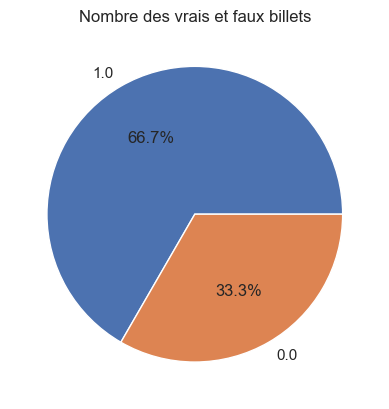

In [449]:
data=train_df['target'].value_counts()
labels=data.index
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Nombre des vrais et faux billets')
plt.show()

1=Vrais
0=faux

## 2.3 Nettoyage des données

In [450]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

target           0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

On a 37 valeurs manquantes dans la colonne margin_low

In [451]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% des données dans la colonne margin_low est manquantes. -> voir la distribution de cette variable

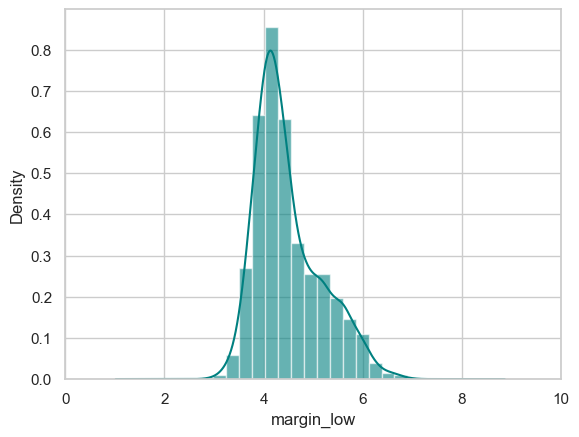

In [452]:
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

la mediane de margin_low est indique entre 4 et 5 mm. On va essayer la regression lineaire pour l'imputation des valeurs manquantes.

### 2.3.1 Imputation des valeurs manquantes

On a un DataFrame qui contient X=6 (features)

## Imputation des valeurs manquantes

les valeurs manquantes sont de type numerique

*** 1. La methode regression lineaire de sklearn ***

In [453]:
#Creation d'une copy de notre DataFrame
df_reg=train_df.copy()

In [454]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test= df_reg[df_reg['margin_low'].isna()] #DataFrame qui contient que des valeurs manquantes dans la colonne margin_low

train = df_reg[~df_reg['margin_low'].isna()] #dataframe sans valeurs manquantes

In [455]:
test.shape

(37, 7)

In [456]:
train.shape

(1463, 7)

In [457]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#les variables explicative (X)
X_train = train.drop(columns=['margin_low']) 
X_train

,target,diagonal,height_left,height_right,margin_up,length
0,1.0,171.81,104.86,104.95,2.89,112.83
1,1.0,171.46,103.36,103.66,2.99,113.09
2,1.0,172.69,104.48,103.50,2.94,113.16
3,1.0,171.36,103.91,103.94,3.01,113.51
4,1.0,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...,...
1495,0.0,171.75,104.38,104.17,3.09,111.28
1496,0.0,172.19,104.63,104.44,3.37,110.97
1497,0.0,171.80,104.01,104.12,3.36,111.95
1498,0.0,172.06,104.28,104.06,3.46,112.25


In [458]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#la variable cible (y) (target)
y_train= train['margin_low']
y_train.shape

(1463,)

In [459]:
## Model
# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [460]:
#creation de la variable X_test
X_test = test.drop(columns=['margin_low'])

In [461]:
# Prédire les valeurs manquantes
y_predicted = model.predict(X_test)

In [462]:
y_predicted.shape

(37,)

In [463]:
# Remplacer les valeurs manquantes par les valeurs prédites
df_reg.loc[df_reg['margin_low'].isna(), 'margin_low'] = y_predicted

In [464]:
y_predicted

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ,
       4.09428392, 4.07412432, 4.12538999, 4.0807278 , 4.07363322,
       4.11897255, 4.18037978, 4.13648423, 4.05106842, 4.17837685,
       4.22555104, 4.11586845, 4.10284101, 4.08184346, 4.09276238,
       4.11250192, 4.15717623, 4.16028787, 4.12193808, 4.12353555,
       4.19842271, 4.10962313, 4.09696025, 4.13384101, 5.25968515,
       5.264817  , 5.28251853, 5.30206887, 5.20035843, 5.1754678 ,
       5.17345045, 5.24675055])

In [465]:
y_predicted.shape

(37,)

In [466]:
#Verification
df_reg.isnull().sum()

target          0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [467]:
# preview adjusted train data
df_reg.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


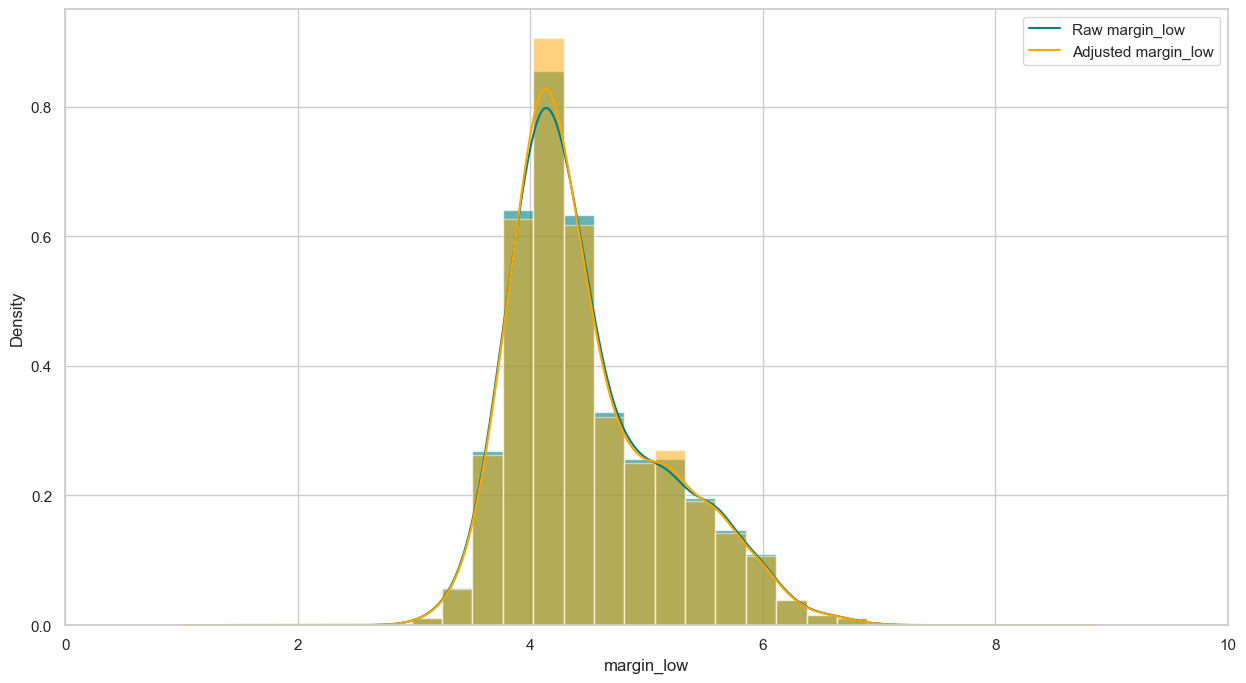

In [468]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_reg["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_reg["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

***la méthode de régression linéaire de Statsmodels***

In [469]:
# Creation d'une copy de DataFrame
df_stat=train_df.copy()

In [470]:
# Séparez vos données en deux ensembles : un ensemble avec des valeurs manquantes et un ensemble sans valeurs manquantes
data_missing = df_stat[df_stat['margin_low'].isnull()]
data_not_missing = df_stat[~df_stat['margin_low'].isnull()]

In [471]:
# Sélectionnez les colonnes que vous souhaitez utiliser pour prédire les valeurs manquantes dans 'colonne_x'
# Par exemple, vous pouvez sélectionner toutes les autres colonnes sauf 'colonne_x'
X = data_not_missing.drop(['margin_low'], axis=1)

# La colonne 'colonne_x' est votre variable cible
y = data_not_missing['margin_low']

In [472]:
# Utilisez la méthode de régression linéaire de Statsmodels pour imputer les valeurs manquantes
model = sm.OLS(y, X).fit()

In [473]:

# Prédisez les valeurs manquantes dans 'colonne_x'
predicted_values = model.predict(data_missing.drop(['margin_low'], axis=1))

In [474]:
# Remplacez les valeurs manquantes par les valeurs prédites
df_stat.loc[df_stat['margin_low'].isnull(), 'margin_low'] = predicted_values

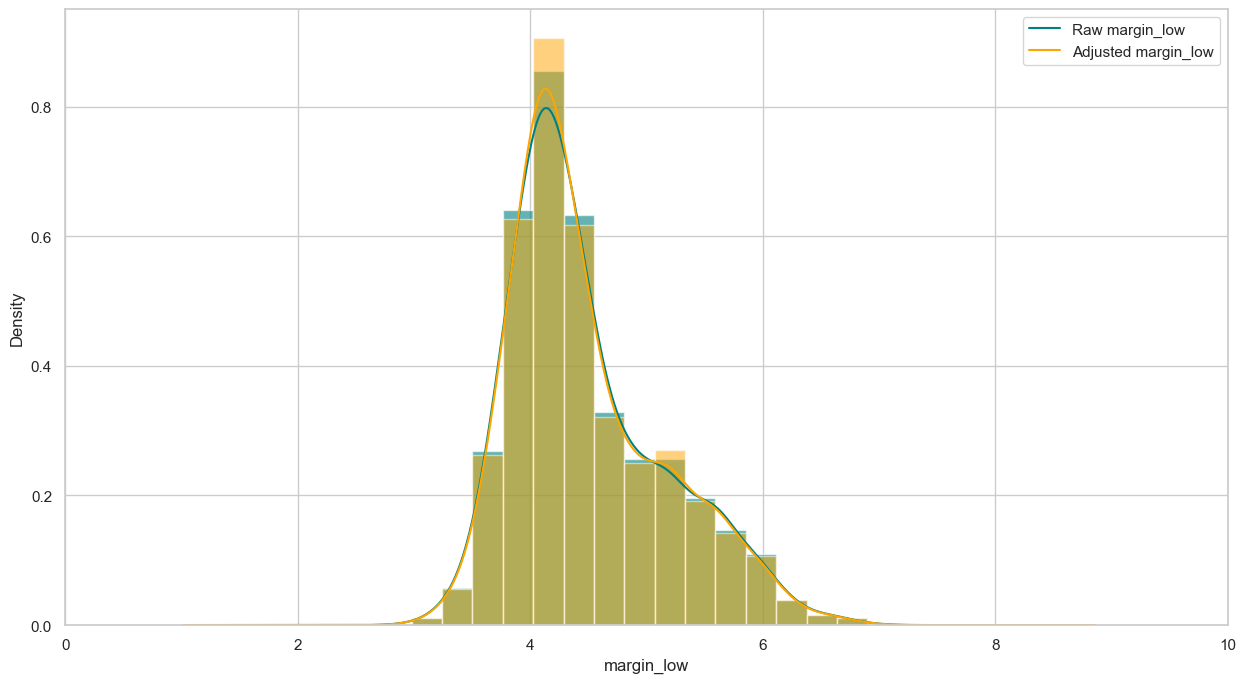

In [475]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_stat["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_stat["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

Exploration des vrais et faux billets avec feachers

In [476]:
df_vrai= train_data.loc[(train_data['target']==1)]
df_faux= train_data.loc[(train_data['target']==0)]

In [477]:
df_vrai.describe()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.0,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,1.0,171.987080,103.949130,103.80865,4.116122,3.05213,113.202430
std,0.0,0.300441,0.300231,0.29157,0.314556,0.18634,0.359552
min,1.0,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,1.0,171.790000,103.740000,103.61000,3.910000,2.93000,112.950000
50%,1.0,171.990000,103.950000,103.81000,4.110995,3.05000,113.205000
75%,1.0,172.200000,104.140000,104.00000,4.330000,3.18000,113.460000
max,1.0,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [478]:
df_faux.describe()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.0,171.901160,104.190340,104.143620,5.216290,3.350160,111.630640
std,0.0,0.306861,0.223758,0.270878,0.549114,0.180498,0.615543
min,0.0,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,0.0,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,0.0,171.910000,104.180000,104.160000,5.195000,3.350000,111.630000
75%,0.0,172.092500,104.332500,104.320000,5.590000,3.472500,112.030000
max,0.0,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [479]:
train_data.describe()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482844,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659899,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


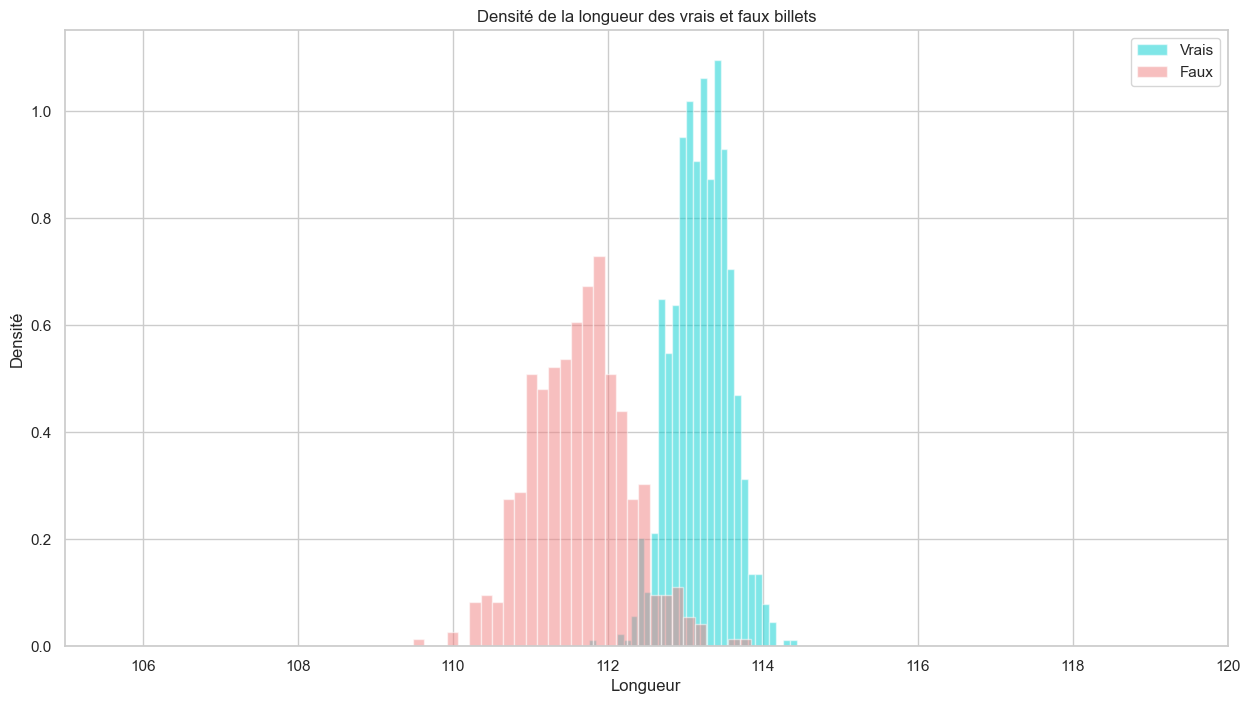

In [480]:
# Séparer les données pour les vrais et les faux billets
vrais = train_data[train_data.target == 1]["length"]
faux = train_data[train_data.target == 0]["length"]

# Tracer les distributions
plt.figure(figsize=(15, 8))
plt.hist(vrais, bins=30, alpha=0.5, color="darkturquoise", label="Vrais", density=True)
plt.hist(faux, bins=30, alpha=0.5, color="lightcoral", label="Faux", density=True)

# Ajouter une légende, un titre et des étiquettes d'axe
plt.legend()
plt.title('Densité de la longueur des vrais et faux billets')
plt.xlabel('Longueur')
plt.ylabel('Densité')

plt.xlim(105, 120)

# Afficher le tracé
plt.show()


La distribution de la variable "longueur" montre que les mesures des faux billets sont plus petites que celles des vrais billets. Cependant, il y a des cas où des billets vrais et faux ont des mesures identiques.

***Exploration des données***

In [481]:
sns.pairplot(train_data, hue="target")
plt.show()

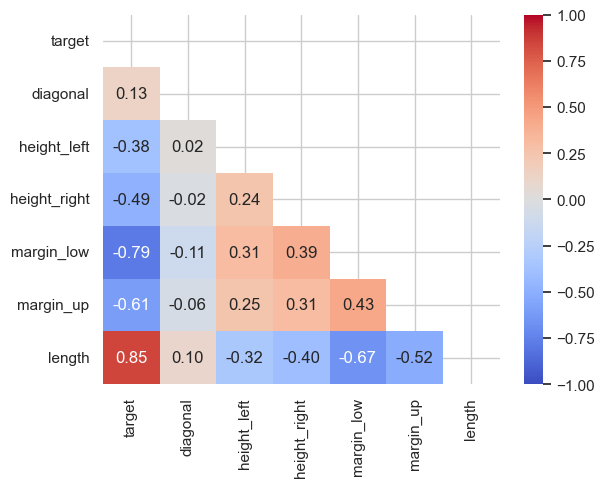

In [ ]:
correlation_matrix = train_data.corr()
masque=np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=masque, vmin=-1, vmax=1)
plt.show()

la target est tres correlée avec la longeur des billets

## 2.3.2 Detection des outliers

In [ ]:
sns.set_theme()

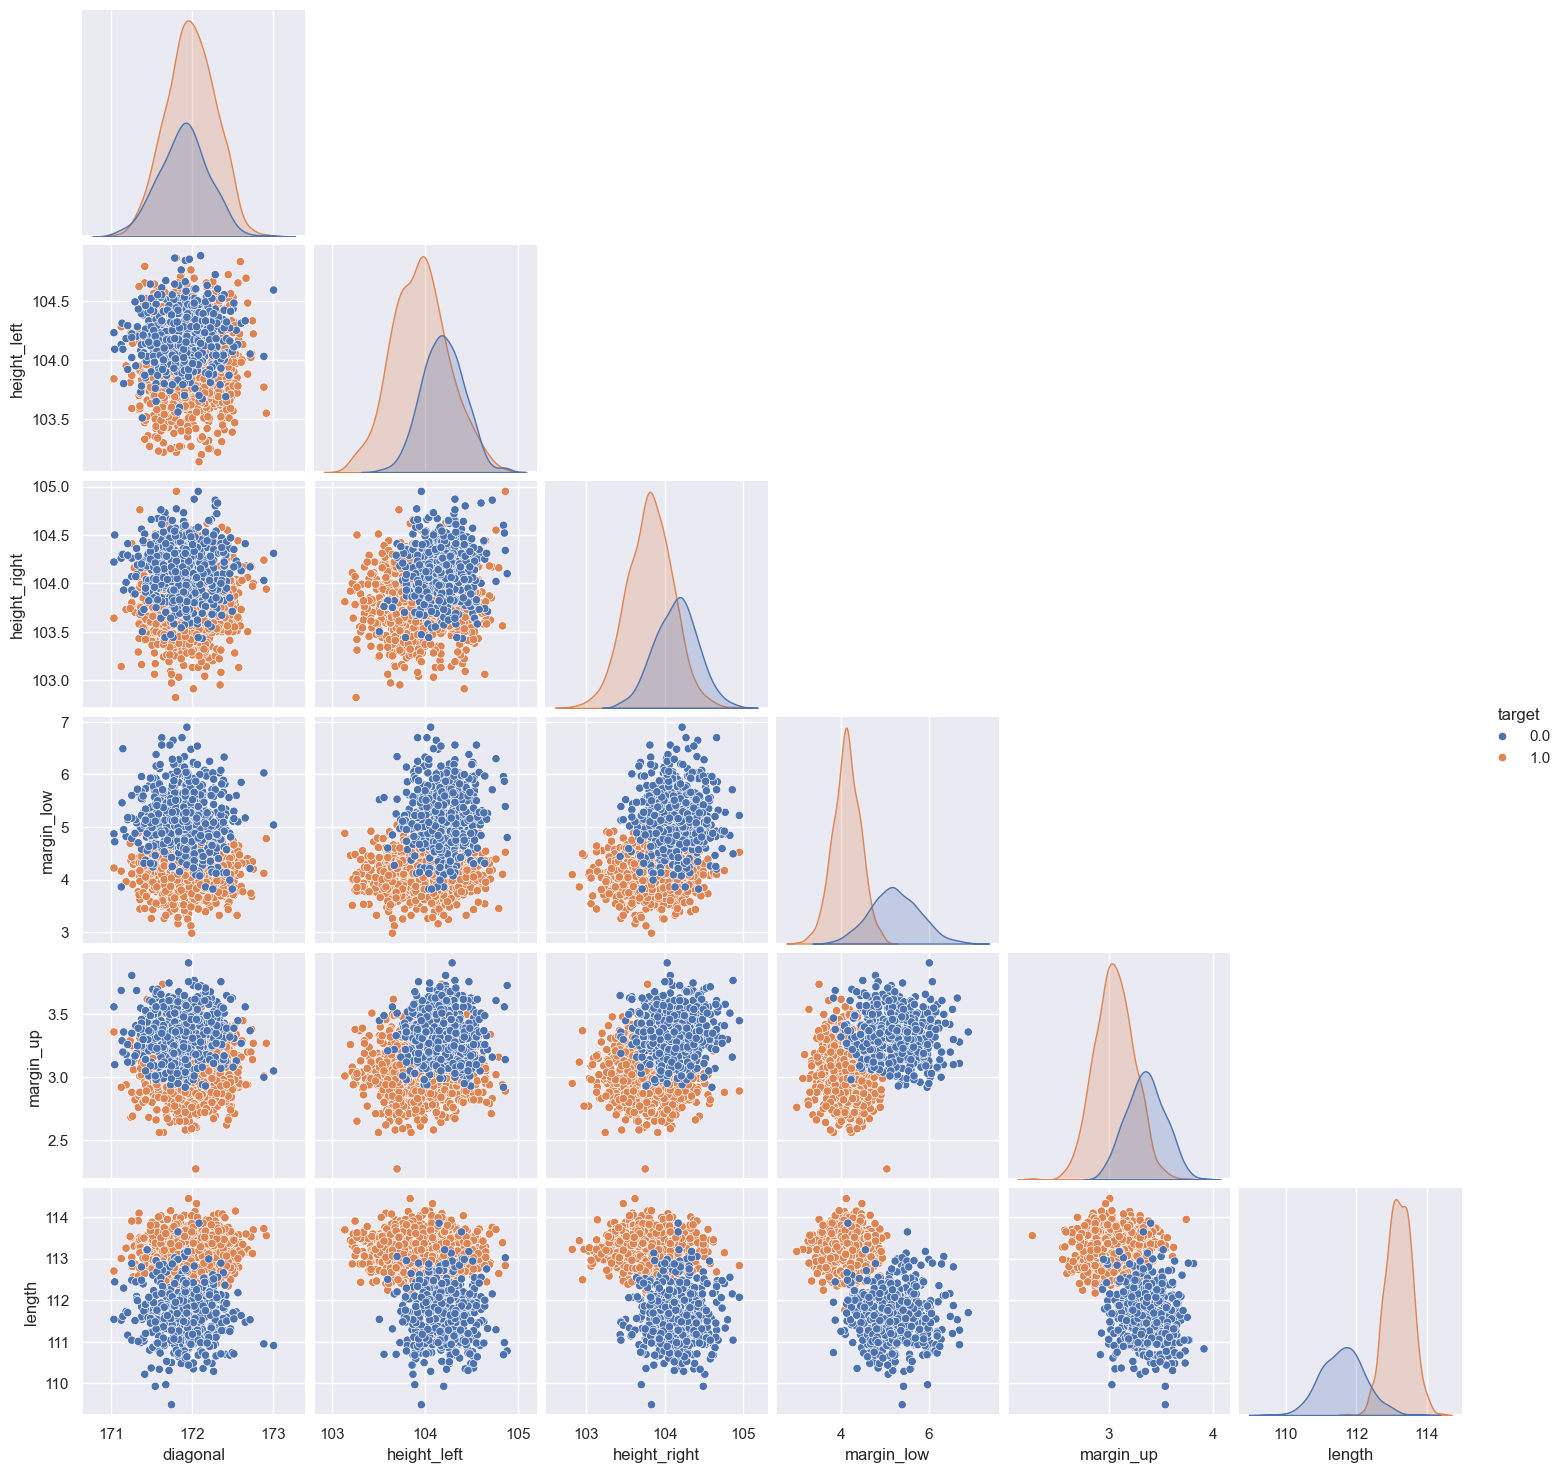

In [ ]:
sns.pairplot(train_data, hue='target', corner=True)

In [ ]:
train_data

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25


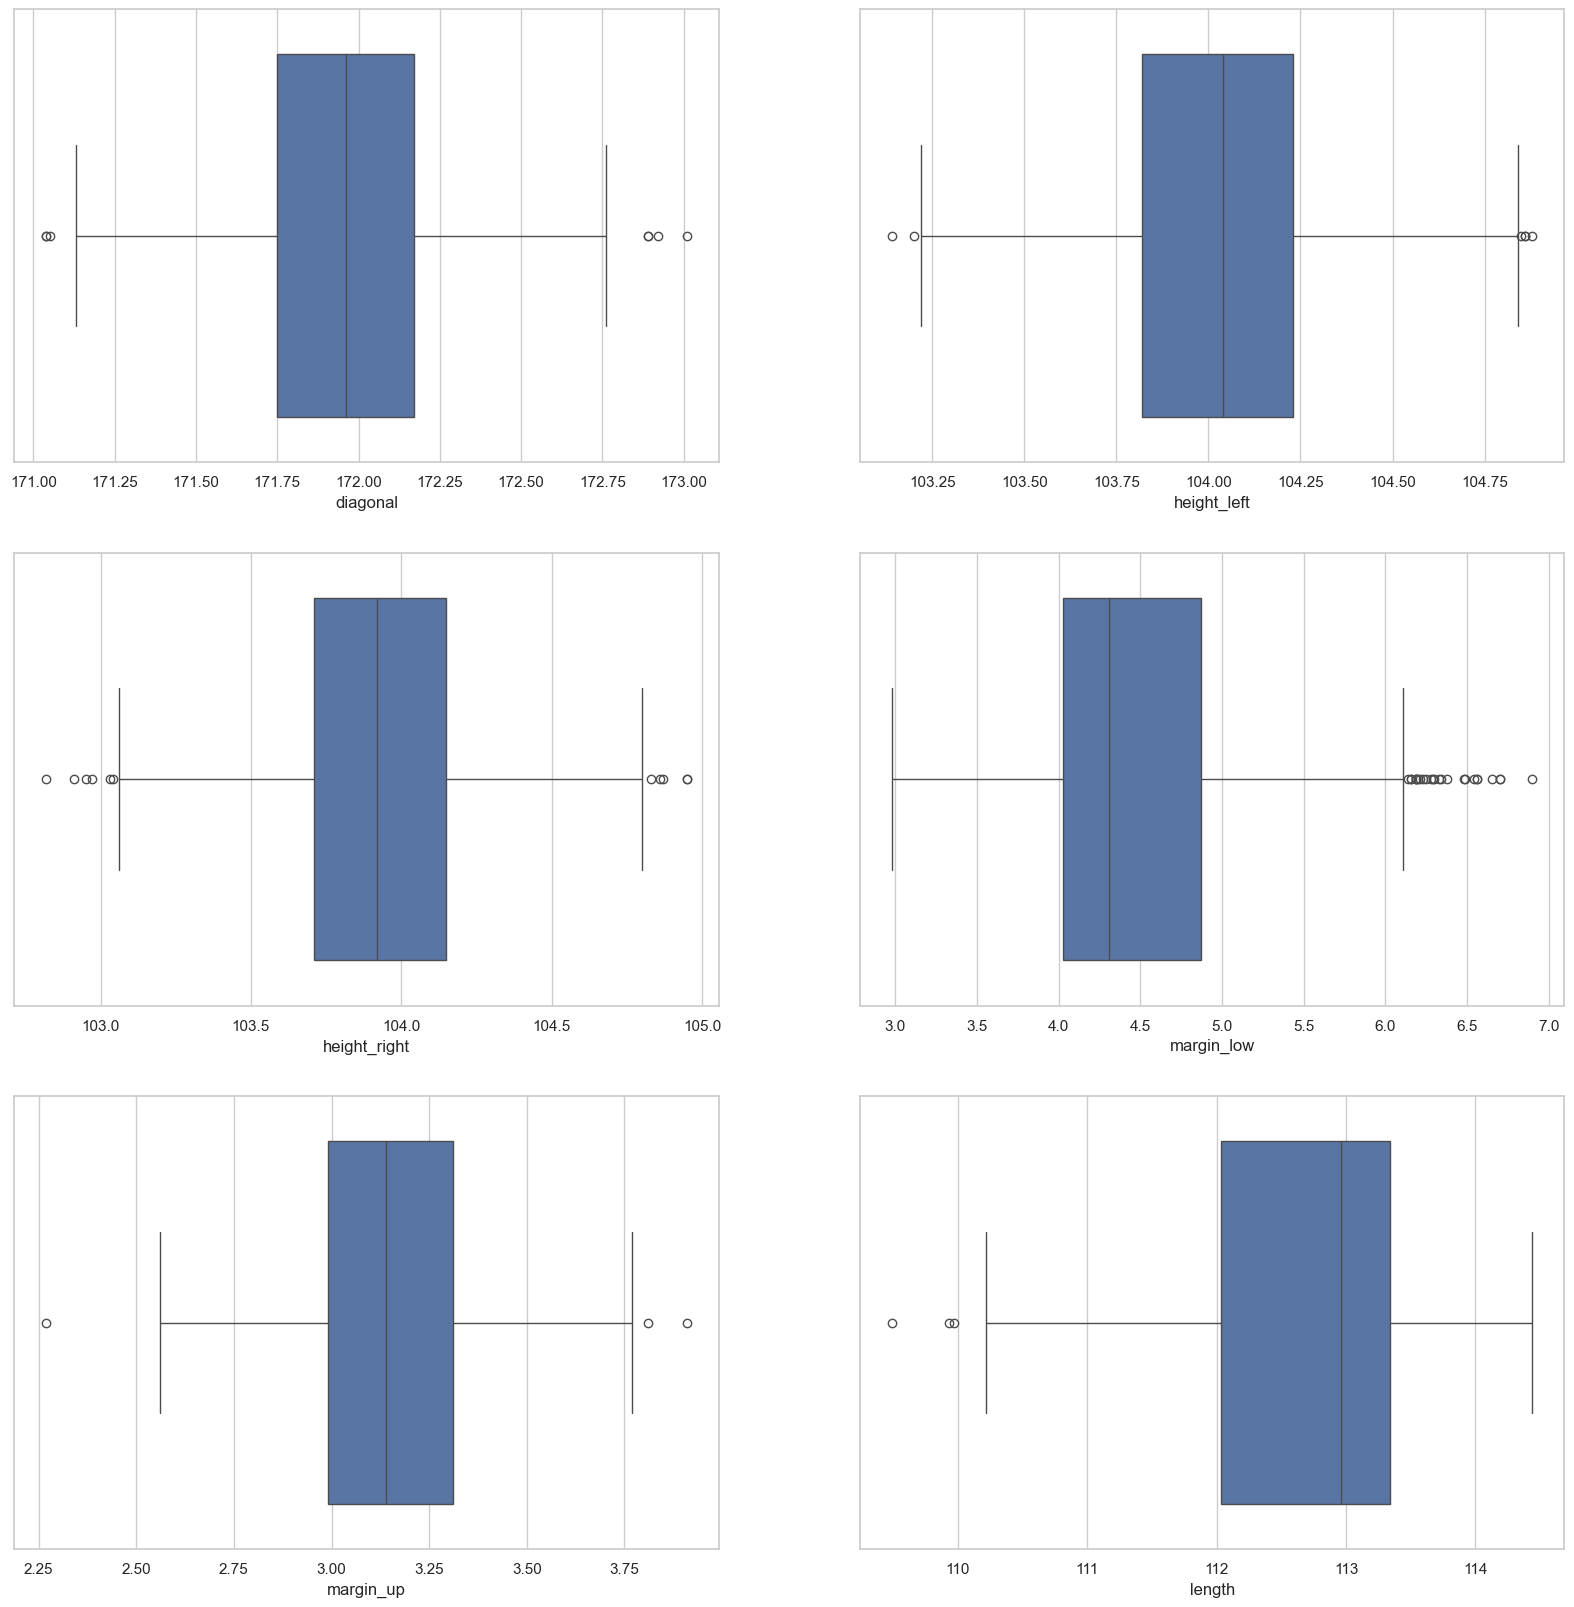

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.set_theme(style="whitegrid")

plt.subplot(321)
sns.boxplot(data=train_data, x='diagonal')

plt.subplot(322)
sns.boxplot(data=train_data, x='height_left')

plt.subplot(323)
sns.boxplot(data=train_data, x='height_right')

plt.subplot(324)
sns.boxplot(data=train_data, x='margin_low')

plt.subplot(325)
sns.boxplot(data=train_data, x='margin_up')

plt.subplot(326)
sns.boxplot(data=train_data, x='length')

plt.show()


Les boxplots montrent des outliers dans plusieurs features. Ceci peut indiquer que ces outliers pourraient être associés aux faux billets qui se distinguent par leurs dimensions non conformes

## 2.3.1.1 Data mining

## 2.4 Preparation des données